In [11]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split

In [12]:
IMAGE_SIZE = 224
BATCH_SIZE = 10
EPOCHS = 10
LATENT_DIM = 32

image_data_dir = 'TEST'
image_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1]
)

image_generator = image_datagen.flow_from_directory(
    image_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input'
)

Found 3962 images belonging to 1 classes.


In [13]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta

    def build(self, input_shape):
        self.embeddings = self.add_weight(
            shape=(self.num_embeddings, self.embedding_dim),
            initializer=tf.keras.initializers.RandomUniform(-1/self.num_embeddings, 1/self.num_embeddings),
            trainable=True,
            name='embeddings'
        )

    def call(self, x):
        input_shape = tf.shape(x)

        flat_x = tf.reshape(x, (-1, self.embedding_dim))

        encoding_indices = self.get_code_indices(flat_x)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings)

        quantized = tf.reshape(quantized, input_shape)

        commitment_loss = tf.reduce_mean(tf.square(tf.stop_gradient(quantized) - x))
        codebook_loss = tf.reduce_mean(tf.square(quantized - tf.stop_gradient(x)))

        quantized = x + tf.stop_gradient(quantized - x)

        extra_loss = self.beta * commitment_loss + codebook_loss
        self.add_loss(extra_loss)
        
        return quantized
    
    def get_code_indices(self, flat_x):
        distances = (
            tf.reduce_sum(flat_x**2, axis=1, keepdims=True) 
            + tf.reduce_sum(self.embeddings**2, axis=1) 
            - 2 * tf.matmul(flat_x, self.embeddings, transpose_b=True)
        )
        return tf.argmin(distances, axis=1)

def build_vqvae_encoder(input_shape, embedding_dim):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(embedding_dim, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    return tf.keras.Model(inputs, x, name='encoder')

def build_vqvae_decoder(embedding_dim, original_shape):
    inputs = layers.Input(shape=(original_shape[0]//8, original_shape[1]//8, embedding_dim))
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(16, (4, 4), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return tf.keras.Model(inputs, outputs, name='decoder')

class VQVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, num_embeddings, embedding_dim, **kwargs):
        super(VQVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim, beta=0.1)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss_tracker = tf.keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            encoded = self.encoder(data)
            quantized = self.vector_quantizer(encoded)
            reconstructed = self.decoder(quantized)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstructed),
                    axis=[1, 2]
                )
            )
            
            vq_loss = sum(self.vector_quantizer.losses)

            total_loss = reconstruction_loss * 10 + vq_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        grads, _ = tf.clip_by_global_norm(grads, 5.0)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(vq_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vq_loss": self.vq_loss_tracker.result()
        }

NUM_CODEBOOK = 512

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
vqvae_encoder = build_vqvae_encoder(input_shape, LATENT_DIM)
vqvae_decoder = build_vqvae_decoder(LATENT_DIM, input_shape)

vqvae = VQVAE(vqvae_encoder, vqvae_decoder, NUM_CODEBOOK, LATENT_DIM)
vqvae.compile(optimizer=Adam(learning_rate=0.0001))

history = vqvae.fit(
    image_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - loss: 473878.1562 - reconstruction_loss: 34731.5039 - vq_loss: 126563.0938
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 56s 141ms/step - loss: 81390920.0000 - reconstruction_loss: 34698.7734 - vq_loss: 81043928.0000
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 56s 140ms/step - loss: 4853365760.0000 - reconstruction_loss: 34695.5625 - vq_loss: 4853018624.0000
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 56s 141ms/step - loss: 49981456384.0000 - reconstruction_loss: 34682.1562 - vq_loss: 49981153280.0000
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - loss: 96044630016.0000 - reconstruction_loss: 34630.4531 - vq_loss: 96044384256.0000
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - loss: 160532561920.0000 - reconstruction_loss: 34504.6680 - vq_loss: 160532365312.0000
Epoch 7/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 55s 138ms/step - loss: 317577854976.0000 - reconstruction_loss: 34052.2891 - vq_loss: 317577723904.0000
Epoch 8/10
397/397 ━

In [14]:
def predict_and_visualize(vqvae, input_images, num_samples=5):
    input_subset = input_images[:num_samples]

    encoded = vqvae.encoder(input_subset)
    quantized = vqvae.vector_quantizer(encoded)
    reconstructed_images = vqvae.decoder(quantized)

    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(input_subset[i])
        plt.axis('off')
        if i == 0:
            plt.title('Original Images')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed Images')
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_batches(vqvae, generator, num_batches=3):
    for _ in range(num_batches):
        images, _ = next(generator)
        predict_and_visualize(vqvae, images, num_samples=2)
        plt.show()

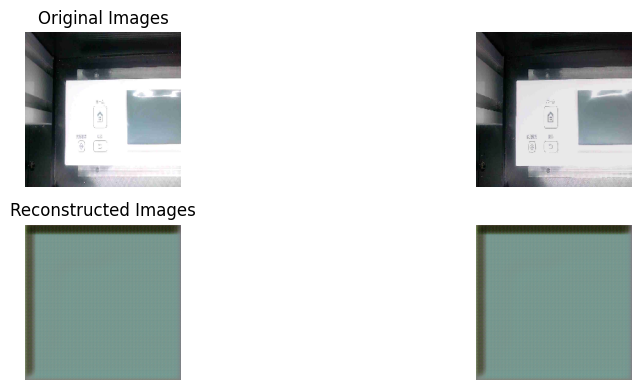

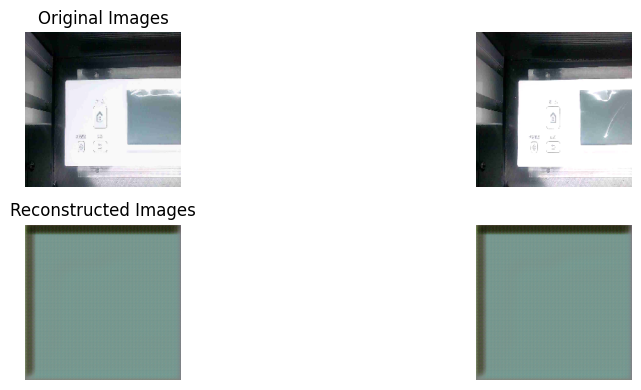

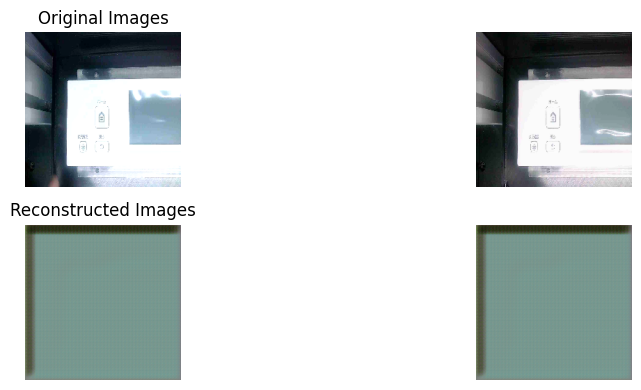

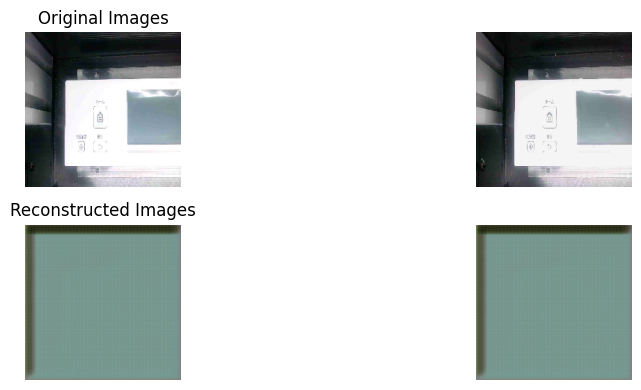

In [15]:
images, _ = next(image_generator)

predict_and_visualize(vqvae, images, num_samples=2)
visualize_multiple_batches(vqvae, image_generator)